In [1]:
import torch
import torch.nn as nn

In [1]:
import torch

# GPU 사용 가능한지 확인
print("CUDA 사용 가능 여부:", torch.cuda.is_available())

# 사용 가능한 GPU 수
print("사용 가능한 GPU 수:", torch.cuda.device_count())

# 현재 선택된 GPU
if torch.cuda.is_available():
    print("현재 사용 중인 GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA 사용 가능 여부: True
사용 가능한 GPU 수: 1
현재 사용 중인 GPU: NVIDIA GeForce GTX 1080


In [3]:
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.Tensor(1, 1, 28, 28)
print(f'텐서의 크기 : {inputs.shape}')

텐서의 크기 : torch.Size([1, 1, 28, 28])


- stride는 default로 stride=(1, 1)

In [ ]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [8]:
# 두번째 Conv2D
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


ceil_mode

- 입력 크기 7x7, kernel_size=2, stride=2라면:

- ceil_mode=False → 출력: 3x3 (7/2 = 3.5 → floor → 3)

- ceil_mode=True → 출력: 4x4 (7/2 = 3.5 → ceil → 4)

In [9]:
# 맥스 풀링
pool = nn.MaxPool2d(2)
print(pool)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [10]:
# 연결하여 모델 만들기
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [11]:
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [12]:
# 두번째 Conv2D 통과
out = conv2(out)
print(out.shape)


torch.Size([1, 64, 14, 14])


In [13]:
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [17]:
out.size(0), out.size(1), out.size(2), out.size(3)

(1, 64, 7, 7)

In [18]:
# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3136])


In [19]:
fc = nn.Linear(3136, 10) # input_dim = 3,136, output_dim = 10
out = fc(out)
print(out.shape)

torch.Size([1, 10])


CNN으로 MNIST 분류하기

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [76]:
learning_rate = 0.001
training_epochs = 15
batch_size = 32

In [ ]:
mnist_train = datasets.MNIST(root='MNIST_data_aug/', # 다운로드 경로 지정
                            train=True, # True를 지정하면 훈련 데이터로 다운로드
                            download=True,
                            transform=transforms.Compose([
                                transforms.RandomRotation(10),              # -10° ~ +10° 회전
                                transforms.RandomAffine(0, translate=(0.1,0.1)),  # 10% 이내 평행 이동
                                transforms.ToTensor(), # 텐서로 변환
                                transforms.Normalize((0.1307,), (0.3081,))   # transforms.Normalize((0.5,), (0.5,))
                            ]))

mnist_test = datasets.MNIST(root='MNIST_data_aug/', # 다운로드 경로 지정
                            train=False, # False를 지정하면 테스트 데이터로 다운로드
                            download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(), # 텐서로 변환
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))

In [78]:
mnist_train, mnist_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: MNIST_data_aug/
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: MNIST_data_aug/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [79]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

valid_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=False)


In [87]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout2d(0.1)        # ← Sequential 안에 포함
        )
       

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        # Conv → ReLU → Pool → Dropout
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout2d(0.1)
        )
        
        # 완전연결 직전 드롭아웃
        self.dropout = torch.nn.Dropout(0.5)

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        
        # 군등분포, 완전연결층(Linear)의 입력·출력 수를 고려해 적절한 스케일로 가중치가 분포하게 됨. 학습 초기에 네트워크가 안정적으로 수렴하도록 돕습니다.
        # 단순·얕은 네트워크에선 생략해도 크게 문제되지 않지만, 관되고 빠른 수렴을 원하거나, 깊은 모델을 다룰 땐 반드시 Xavier(또는 He) 초기화를 적용하는 것이 좋습니다.
        
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.dropout(out)           # ← 여기에 Dropout 적용
        out = self.fc(out)
        return out

In [88]:
# CNN 모델 정의
model = CNN().to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# L2 Regularization / Weight Decay
# 학습률로 전역 스텝 크기를 제어하면서, weight decay로 모델 복잡도를 억제하여, 과적합을 줄이고, 수렴 속도와 안정성을 함께 얻을 수 있음
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4   # 보통 1e-3 ~ 1e-5 사이 값 사용
)

In [90]:
total_train_batch = len(train_loader)
total_test_batch = len(valid_loader)
print(f'총 배치의 수 : {total_train_batch}, {total_test_batch}')

총 배치의 수 : 1875, 313


In [91]:
len(train_loader), len(train_loader.dataset)

(1875, 60000)

In [92]:
from tqdm import tqdm

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

num_epochs = 10
for epoch in range(num_epochs):  # Loop for num epochs
    model.train()  # Set the model to training mode
    total_train_loss, total_valid_loss = 0.0, 0.0
    total_train_correct, total_valid_correct = 0.0, 0.0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}", unit=" batch")):  # Iterate over batches of data
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()  # Clear gradients from the previous iteration
        output = model(data)  # Forward pass through the model
        loss = criterion(output, target)  # Calculate the loss
        loss.backward()  # Compute gradients (backpropagation)
        optimizer.step()  # Update model parameters
        
        total_train_loss += loss.item() * data.size(0)  # Accumulate test loss
        
        pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
        total_train_correct += pred.eq(target.view_as(pred)).sum().item()  # Update correct predictions 
        # print('train_correct', train_correct)
        
    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0
    total_valid_correct = 0
    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data, target in valid_loader:  # Iterate over test data
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            total_valid_loss += criterion(output, target).item() * data.size(0) # Accumulate test loss
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            total_valid_correct += pred.eq(target.view_as(pred)).sum().item()  # Update correct predictions
    
    # calculate average loss over an epoch
    train_loss = total_train_loss/len(train_loader.dataset)
    valid_loss = total_valid_loss/len(valid_loader.dataset)
    train_correct = total_train_correct/len(train_loader.dataset)
    valid_correct = total_valid_correct/len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_correct)
    valid_accs.append(valid_correct)
    
    # tqdm 상태창에 추가 정보 표시
    tqdm.write(f"[{epoch}/{num_epochs}] Batch {batch_idx} Training Loss: {train_loss:.3f} Valid Loss: {valid_loss:.3f}  Training Accuracy: {100. * train_correct:.3f}% \
 Valid Accuracy: {100. * valid_correct:.3f}% \n")
    

Epoch 0: 100%|██████████| 1875/1875 [00:34<00:00, 55.07 batch/s]


[0/10] Batch 1874 Training Loss: 0.495 Valid Loss: 0.062  Training Accuracy: 84.350%  Valid Accuracy: 98.090% 



Epoch 1: 100%|██████████| 1875/1875 [00:33<00:00, 56.67 batch/s]


[1/10] Batch 1874 Training Loss: 0.220 Valid Loss: 0.049  Training Accuracy: 93.115%  Valid Accuracy: 98.570% 



Epoch 2: 100%|██████████| 1875/1875 [00:33<00:00, 55.36 batch/s]


[2/10] Batch 1874 Training Loss: 0.177 Valid Loss: 0.039  Training Accuracy: 94.480%  Valid Accuracy: 98.750% 



Epoch 3: 100%|██████████| 1875/1875 [00:33<00:00, 56.68 batch/s]


[3/10] Batch 1874 Training Loss: 0.161 Valid Loss: 0.039  Training Accuracy: 95.123%  Valid Accuracy: 98.750% 



Epoch 4: 100%|██████████| 1875/1875 [00:33<00:00, 56.39 batch/s]


[4/10] Batch 1874 Training Loss: 0.141 Valid Loss: 0.034  Training Accuracy: 95.578%  Valid Accuracy: 98.990% 



Epoch 5: 100%|██████████| 1875/1875 [00:33<00:00, 55.87 batch/s]


[5/10] Batch 1874 Training Loss: 0.130 Valid Loss: 0.030  Training Accuracy: 95.908%  Valid Accuracy: 99.110% 



Epoch 6: 100%|██████████| 1875/1875 [00:33<00:00, 56.16 batch/s]


[6/10] Batch 1874 Training Loss: 0.126 Valid Loss: 0.029  Training Accuracy: 96.118%  Valid Accuracy: 99.200% 



Epoch 7: 100%|██████████| 1875/1875 [00:35<00:00, 53.25 batch/s]


[7/10] Batch 1874 Training Loss: 0.117 Valid Loss: 0.029  Training Accuracy: 96.448%  Valid Accuracy: 99.070% 



Epoch 8: 100%|██████████| 1875/1875 [00:33<00:00, 56.26 batch/s]


[8/10] Batch 1874 Training Loss: 0.115 Valid Loss: 0.026  Training Accuracy: 96.413%  Valid Accuracy: 99.150% 



Epoch 9: 100%|██████████| 1875/1875 [00:33<00:00, 55.52 batch/s]


[9/10] Batch 1874 Training Loss: 0.113 Valid Loss: 0.029  Training Accuracy: 96.438%  Valid Accuracy: 99.190% 



In [101]:
train_losses

[0.11528463509061233,
 0.04372670180717281,
 0.03056907778675321,
 0.02306502896132319,
 0.017527709531443832,
 0.014129334224187601,
 0.011429801792606354,
 0.009327251552569086,
 0.00805066347954928,
 0.0072853475135329915]

In [102]:
valid_losses

[0.04859343039018859,
 0.03343899858261909,
 0.02600381782552995,
 0.026266007762165346,
 0.03232843687633144,
 0.027044677751293243,
 0.03403401670857899,
 0.03827963621091365,
 0.03864655192149169,
 0.03934948537573797]

In [ ]:
train_losses, valid_losses = [], []
train_accs,   valid_accs  = [], []

for epoch in range(30):
    # ── 학습
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss   = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss   += loss.item() * data.size(0)
        total_train_correct += output.argmax(1).eq(target).sum().item()

    # ── 평가
    model.eval()
    total_valid_loss = 0.0
    total_valid_correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            total_valid_loss    += criterion(output, target).item() * data.size(0)
            total_valid_correct += output.argmax(1).eq(target).sum().item()

    # ── 평균 계산
    train_loss = total_train_loss / len(train_loader.dataset)
    valid_loss = total_valid_loss / len(valid_loader.dataset)

    train_acc = total_train_correct / len(train_loader.dataset)
    valid_acc = total_valid_correct / len(valid_loader.dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(
        f'Epoch: {epoch}  '
        f'Train Loss: {train_loss:.3f}  '
        f'Valid Loss: {valid_loss:.3f}  '
        f'Train Acc: {train_acc*100:.3f}%  '
        f'Valid Acc: {valid_acc*100:.3f}%'
    )


Epoch: 0  Train Loss: 0.117  Valid Loss: 0.043  Train Acc: 96.432%  Valid Acc: 98.590%
Epoch: 1  Train Loss: 0.043  Valid Loss: 0.036  Train Acc: 98.643%  Valid Acc: 98.800%
Epoch: 2  Train Loss: 0.032  Valid Loss: 0.037  Train Acc: 98.972%  Valid Acc: 98.800%
Epoch: 3  Train Loss: 0.023  Valid Loss: 0.039  Train Acc: 99.307%  Valid Acc: 98.750%
Epoch: 4  Train Loss: 0.018  Valid Loss: 0.042  Train Acc: 99.432%  Valid Acc: 98.690%
Epoch: 5  Train Loss: 0.014  Valid Loss: 0.036  Train Acc: 99.533%  Valid Acc: 98.910%
Epoch: 6  Train Loss: 0.012  Valid Loss: 0.036  Train Acc: 99.627%  Valid Acc: 99.080%
Epoch: 7  Train Loss: 0.011  Valid Loss: 0.035  Train Acc: 99.652%  Valid Acc: 99.050%
Epoch: 8  Train Loss: 0.008  Valid Loss: 0.036  Train Acc: 99.740%  Valid Acc: 99.140%
Epoch: 9  Train Loss: 0.008  Valid Loss: 0.042  Train Acc: 99.730%  Valid Acc: 99.100%
Epoch: 10  Train Loss: 0.006  Valid Loss: 0.045  Train Acc: 99.785%  Valid Acc: 99.090%
Epoch: 11  Train Loss: 0.006  Valid Loss: 

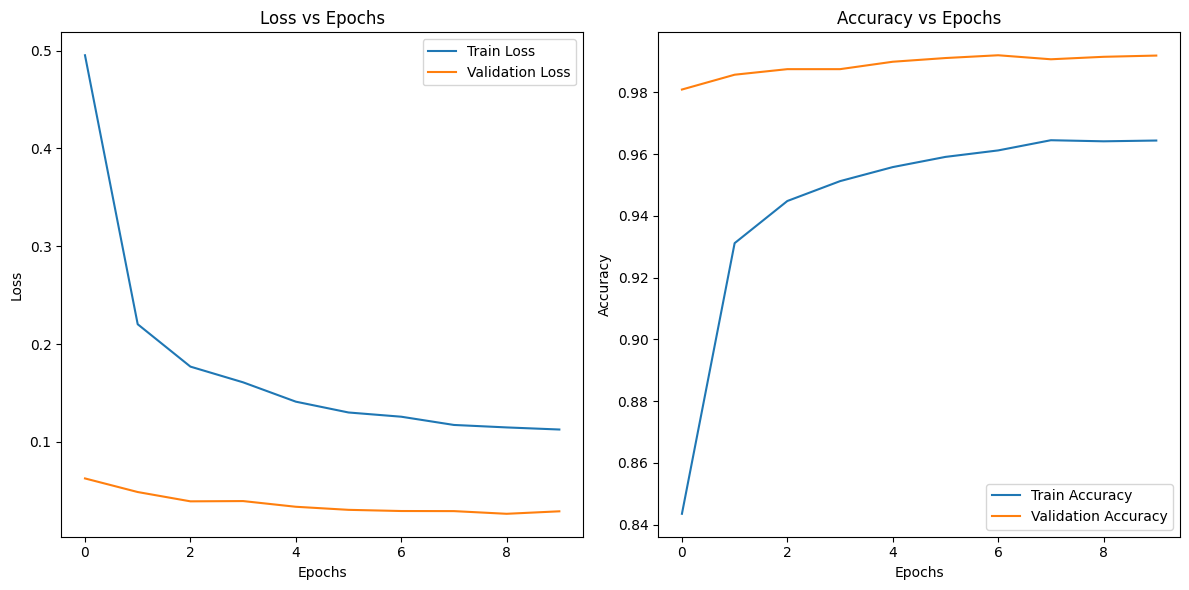

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# # 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
# with torch.no_grad():
#     # 테스트 데이터를 모델에 입력하기 위한 준비
#     X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)  # 테스트 데이터셋의 크기를 맞추고, 연산을 위한 장치로 이동
#     Y_test = mnist_test.targets.to(device)  # 테스트 데이터셋의 레이블을 연산을 위한 장치로 이동
    
#     print(X_test.shape)

#     # 모델 예측 수행
#     prediction = model(X_test)  # 테스트 데이터에 대해 모델이 예측한 결과값

#     # 예측 결과와 실제 레이블 비교
#     correct_prediction = torch.argmax(prediction, 1) == Y_test  # 예측된 클래스와 실제 레이블이 일치하는지 확인

#     # 정확도 계산
#     accuracy = correct_prediction.float().mean()  # 정확도를 계산하기 위해 일치하는 예측의 평균을 구함
#     print('Accuracy:', accuracy.item())  # 정확도를 출력


torch.Size([10000, 1, 28, 28])
Accuracy: 0.9858999848365784
